# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [71]:
from keras.src.saving.saving_api import load_model
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
import sys
from collections import deque  
import math


#graficos
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import io
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

## 2. INICIALIZAR MEDIAPIPE

In [72]:
# Configuración inicial global
mp_hands = mp.solutions.hands

# Optimizar MediaPipe
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.45,  # Reducir confianza
    min_tracking_confidence=0.45,
    model_complexity=0  # Menor complejidad
)

mp_draw = mp.solutions.drawing_utils
dataset_dir = "dataset_11_90"
model_path = "gesture_model_me_10_90_pruebas_2.h5"
sequence_length = 90
total_landmarks = 126
gestures = []
X_mean = None
X_std = None

num_camara = 0

## 3. FUNCIONES PRINCIPALES

In [73]:
# Funciones principales
def init_system():
    global gestures
    os.makedirs(dataset_dir, exist_ok=True)
    gestures = get_existing_gestures()
    
def get_existing_gestures():
    return sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])


## 4. DETECCION DE MANO

In [74]:
def detect_hands():
    print("\nIniciando detección de manos. Presiona 'ESC' para salir.")
    cap = cv2.VideoCapture(0)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow("Detección de Manos", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

## 5. RECOLLECION DE DATOS 

In [75]:
def collect_data():
    global gestures
    gesture = input("\nIngrese la palabra o letra para la cual desea recolectar datos: ").upper()
    num_sequences = int(input("Ingrese el número de secuencias a capturar (recomendado: 50): "))
    
    save_dir = os.path.join(dataset_dir, gesture)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nRecolectando datos para el gesto '{gesture}'. Presiona 'ESC' para cancelar.")
    print("Mantenga la seña frente a la cámara...")
    
    cap = cv2.VideoCapture(0)
    sequence = []
    counter = 0

    #NUEVO Configurar ventana de landmarks
    landmark_window_name = "Landmarks en Tiempo Real"
    cv2.namedWindow(landmark_window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(landmark_window_name, 640, 480)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        #NUEVO Crear canvas para landmarks
        landmark_canvas = np.zeros((480, 640, 3), dtype=np.uint8)  # Canvas negro 640x480

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            all_landmarks = []

            #NUEVO Dibujar landmarks en el canvas
            for hand_landmarks in results.multi_hand_landmarks:
                # Dibujar en el canvas negro
                mp_draw.draw_landmarks(
                    landmark_canvas,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_draw.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                    mp_draw.DrawingSpec(color=(0, 0, 255), thickness=2)
                )
            
            # Extraer coordenadas para el dataset
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            # Rellenar si solo hay una mano
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)

            # Dibujar en el frame original
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        if len(sequence) == sequence_length:
            np.save(os.path.join(save_dir, f"secuencia_{counter}.npy"), sequence)
            counter += 1
            sequence = []
            print(f"Secuencias capturadas: {counter}/{num_sequences}")

        #NUEVO Mostrar información en ambas ventanas
        info_text = f"Secuencias: {counter}/{num_sequences}"
        cv2.putText(frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(landmark_canvas, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


        cv2.imshow("Recolección de Datos", frame)
        #NEUVO
        cv2.imshow(landmark_window_name, landmark_canvas)
        if cv2.waitKey(1) & 0xFF == 27 or counter >= num_sequences:
            break

    cap.release()
    cv2.destroyAllWindows()
    gestures = get_existing_gestures()
    print(f"\nSe recolectaron {counter} secuencias para el gesto '{gesture}'")

## 6. CARGA DE DATOS

In [76]:
def custom_augmentation(sequence):
    """Aumentación 100% en TensorFlow"""
    # 1. Ruido Gaussiano
    noise = tf.random.normal(tf.shape(sequence), mean=0.0, stddev=0.05)

    # Convertir explícitamente a float32
    sequence = tf.cast(sequence, tf.float32)
    # 1. Ruido Gaussiano
    noise = tf.random.normal(tf.shape(sequence), mean=0.0, stddev=0.05)
    sequence = tf.add(sequence, noise)
    
    # 2. Escalado aleatorio
    scale_factor = tf.random.uniform([], 0.9, 1.1)
    sequence = tf.multiply(sequence, scale_factor)
    
    # 3. Rotación 2D (versión TensorFlow)
    angle = tf.random.uniform([], -15.0, 15.0)  # Grados
    angle_rad = tf.math.divide(angle * math.pi, 180.0)
    
    # Crear matriz de rotación como tensor
    rot_matrix = tf.stack([
        [tf.cos(angle_rad), -tf.sin(angle_rad), 0.0],
        [tf.sin(angle_rad), tf.cos(angle_rad), 0.0],
        [0.0, 0.0, 1.0]
    ])
    
    # Aplicar rotación a cada landmark
    original_shape = tf.shape(sequence)
    sequence = tf.reshape(sequence, [-1, 3])  # [secuencia_length*42, 3]
    sequence = tf.matmul(sequence, rot_matrix)
    sequence = tf.reshape(sequence, original_shape)
    
    # 4. Desplazamiento temporal (versión TensorFlow)
    shift = tf.random.uniform([], -5, 5, dtype=tf.int32)
    sequence = tf.cond(
        tf.random.uniform([]) > 0.5,
        lambda: tf.roll(sequence, shift=shift, axis=0),
        lambda: sequence
    )

    
    return sequence

# Modificar la función create_dataset
def create_dataset(X_data, y_data, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    
    if augment:
        dataset = dataset.map(
            lambda x, y: (custom_augmentation(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.shuffle(1000)
    
    return dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
def load_data(augment=True):
    X = []
    y = []
    
    for label_idx, gesture in enumerate(gestures):
        gesture_dir = os.path.join(dataset_dir, gesture)
        sequences = [f for f in os.listdir(gesture_dir) if f.endswith('.npy')]
        print(f"Gesto '{gesture}' - secuencias encontradas: {len(sequences)}")
        
        for seq_file in sequences:
            seq_path = os.path.join(gesture_dir, seq_file)
            sequence = np.load(seq_path)
            
            if sequence.shape == (sequence_length, total_landmarks):
                X.append(sequence)
                y.append(label_idx)
            else:
                print(f"Secuencia {seq_file} con forma {sequence.shape} ignorada.")
    
    return np.array(X, dtype=np.float32), np.array(y), gestures  # Asegurar tipo float32


## 7. ENTRENAMIENTO DEL MODELO

In [78]:
def train_model():
    
    import time

    global X_mean, X_std, gestures
    
    # 1. Verificar datos de entrenamiento
    gestures = get_existing_gestures()
    if not gestures:
        print("\nNo hay datos recolectados. Primero recolecte datos de gestos.")
        return

    # 2. Cargar y preparar datos
    print("\nCargando datos y preparando el entrenamiento...")
    X, y, gestures = load_data(augment=False)  # Cargar sin aumentación inicial
    y = tf.keras.utils.to_categorical(y)

    # 3. Dividir datos antes de crear el Dataset
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # 4. Calcular parámetros de normalización
    X_mean = np.mean(X_train, axis=(0, 1)).astype(np.float32)
    X_std = np.std(X_train, axis=(0, 1)).astype(np.float32)
    X_train = (X_train - X_mean) / X_std
    X_val = (X_val - X_mean) / X_std  # Aplicar misma normalización a validación

    train_dataset = create_dataset(X_train, y_train, augment=True)
    val_dataset = create_dataset(X_val, y_val, augment=False)
    

    # 4. Guardar parámetros de normalización
    np.savez('normalization_params_90_pruebas_2.npz', mean=X_mean, std=X_std)
    
    # 5. Arquitectura optimizada del modelo
    # Modelo CNN + LSTM Bidireccional
    """inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))
    x = tf.keras.layers.Conv1D(128, 5, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64))(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(len(gestures), activation='softmax')(x)"""

      # Arquitectura del modelo mejorada
    inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))
    x = tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.LSTM(32)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = tf.keras.layers.Dense(len(gestures), activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    # 6. Compilación y entrenamiento
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()



    # Calcular pesos con datos de entrenamiento
    y_train_true = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_true), y=y_train_true)
    class_weights = dict(enumerate(class_weights))

    print("\nIniciando entrenamiento...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,  # Usar dataset de validación explícito
        class_weight=class_weights,  # Añadir este parámetro
        epochs=50,
        verbose=1
    )

     # Función para graficar métricas de entrenamiento
    def generate_training_plots(history):
        # Crear figura de 12x5 pulgadas (ancho x alto)
        plt.figure(figsize=(12, 5))
        
        # Primer subgráfico (1 fila, 2 columnas, posición 1)
        plt.subplot(1, 2, 1)
        # Graficar precisión de entrenamiento (datos del historial)
        plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
        # Graficar precisión de validación (línea punteada)
        plt.plot(history.history['val_accuracy'], '--', label='Precisión Validación')
        plt.title('Evolución de la Precisión')
        plt.ylabel('Precisión')  # Rango 0-1 (0% a 100%)
        plt.ylim([0, 1])  # Para precisión entre 0-100%
        plt.xlabel('Época')  # Iteración de entrenamiento
        plt.legend()  # Mostrar etiquetas
        plt.grid(True, linestyle='--', alpha=0.5)  # Cuadrícula suave

        # Segundo subgráfico (posición 2)
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
        plt.plot(history.history['val_loss'], '--', label='Pérdida Validación')
        plt.title('Evolución de la Pérdida')
        plt.ylabel('Pérdida')  # Valor de la función de costo
        plt.xlabel('Época')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

        # Ajustar espacios entre subgráficos
        plt.tight_layout()
        # Guardar como imagen PNG (calidad vectorial)
        plt.savefig(f'confusion_matrix_{int(time.time())}.png')
        plt.show()  # Mostrar en pantalla

        # Función para matriz de confusión
    def generate_confusion_matrix(model, X_val, y_val):
        # Obtener etiquetas verdaderas (índices de mayor probabilidad)
        y_true = np.argmax(y_val, axis=1)
        # Predecir y obtener índices de clases
        y_pred = np.argmax(model.predict(X_val), axis=1)
        
        # Calcular matriz de confusión (formato numérico)
        cm = confusion_matrix(y_true, y_pred)
    
        # Crear figura para el heatmap
        plt.figure(figsize=(10, 8))
        # Heatmap con anotaciones numéricas
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=gestures,  # Nombres clases en X
                    yticklabels=gestures)  # Nombres clases en Y
        plt.title('Matriz de Confusión', pad=20)
        plt.xlabel('Predicciones del Modelo')
        plt.ylabel('Etiquetas Reales')
        # Rotar etiquetas X 45 grados para mejor legibilidad
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        # Ajustar márgenes
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300)
        plt.show()

        # Reporte detallado de métricas
        print("\nReporte de Clasificación:")
        print(classification_report(y_true, y_pred, 
                                target_names=gestures,
                                digits=3))  # 3 decimales
        
    # 7. Guardar modelo y resultados
    model.save(model_path)
    generate_training_plots(history)
    generate_confusion_matrix(model, X_val, y_val)
    print(f"\nModelo guardado en {model_path}")
    
    # 8. Conversión a TFLite con configuraciones especiales
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    
    try:
        tflite_model = converter.convert()
        with open('model_quantized_90_pruebas_2.tflite', 'wb') as f:
            f.write(tflite_model)
        print("\nModelo TFLite exportado exitosamente")
    except Exception as e:
        print(f"\nError en conversión TFLite: {str(e)}")
    
    # Mostrar métricas finales
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Precisión de validación final: {val_accuracy:.2%}")

## TF LITE

In [79]:
def convert_to_tflite():
    try:
        # Cargar el modelo entrenado
        model = tf.keras.models.load_model(model_path)
        
        # Configurar el conversor con parámetros especiales
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        
        # Añadir estas 3 líneas clave para compatibilidad con LSTM
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        converter._experimental_lower_tensor_list_ops = False
        converter.allow_custom_ops = True  # Permitir operaciones personalizadas
        
        # Realizar la conversión
        tflite_model = converter.convert()
        
        # Guardar el modelo cuantizado
        with open('model_quantized_90_pruebas_2.tflite', 'wb') as f:
            f.write(tflite_model)
            
        print("\n✅ Conversión a TFLite exitosa!")
        
    except Exception as e:
        print(f"\n❌ Error en conversión: {str(e)}")
        print("Posibles soluciones:")
        print("1. Verifique que el modelo .h5 existe")
        print("2. Actualice TensorFlow: pip install --upgrade tensorflow")
        print("3. Reinicie el runtime/kernel")

    global gestures
    gestures = get_existing_gestures()
    print("Gestos cargados para evaluación:", gestures)

    print("Salida del modelo:", model.output_shape)



def representative_dataset_gen():
    # Generador de datos de ejemplo para calibración
    for _ in range(100):
        yield [np.random.randn(1, sequence_length, total_landmarks).astype(np.float32)]

## 8. EVALUACION DEL MODELO

In [80]:
from threading import Thread
# -----------------PROYECTO FINAL - VERSIÓN MEJORADA-----------------
## 8. EVALUACION DEL MODELO (CORRECCIÓN CRÍTICA)
def evaluate():

    global gestures
    gestures = get_existing_gestures()


    if not os.path.exists("model_quantized_90_pruebas_2.tflite"):
        print("\n¡Primero debe entrenar y convertir el modelo!")
        return
    
    # 1. Cargar parámetros y modelo
    try:
        with np.load('normalization_params_90_pruebas_2.npz') as data:
            X_mean = data['mean']
            X_std = data['std']
            
        interpreter = tf.lite.Interpreter(model_path="model_quantized_90_pruebas_2.tflite")
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]
        print("Output details shape:", output_details['shape'])
    except Exception as e:
        print(f"\nError crítico: {str(e)}")
        return

    
    # 2. Configuración de cámara
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    
    if not cap.isOpened():
        print("\n¡No se puede acceder a la cámara!")
        return

    # 3. Variables de estado mejoradas
    sequence = deque(maxlen=sequence_length)
    prediction_history = deque(maxlen=15)  # Suavizado de predicciones
    current_gesture = "Esperando..."
    current_confidence = 0.0

    # 4. Bucle principal optimizado
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Procesamiento cada 2 frames para mejor rendimiento
        if cv2.waitKey(1) & 0xFF == 27:
            break
        
        # Siempre procesar landmarks (manos detectadas o no)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        landmarks = []
        
        if results.multi_hand_landmarks:
            # Extraer landmarks para ambas manos
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
            
            # Rellenar con ceros si es necesario
            if len(landmarks) < total_landmarks:
                landmarks += [0.0] * (total_landmarks - len(landmarks))
        else:
            # Si no hay manos, usar ceros
            landmarks = [0.0] * total_landmarks
        
        sequence.append(landmarks)
        
        # Realizar predicción cuando la secuencia esté completa
        if len(sequence) == sequence_length:
            try:
                # Preprocesamiento y normalización
                seq_array = np.array(sequence)
                seq_array = (seq_array - X_mean) / (X_std + 1e-7)
                input_data = seq_array.reshape(1, sequence_length, total_landmarks).astype(np.float32)

                
                # Durante la evaluación, agregar testeo de forma
                if input_data.shape != tuple(input_details['shape']):
                    print(f"Error: Forma esperada {input_details['shape']}, obtenida {input_data.shape}")
                    return
                
                # Inferencia
                interpreter.set_tensor(input_details['index'], input_data)
                interpreter.invoke()
                prediction = interpreter.get_tensor(output_details['index'])[0]
                
                # Procesar resultados con suavizado
                predicted_idx = np.argmax(prediction)
                confidence = prediction[predicted_idx]
                prediction_history.append((predicted_idx, confidence))
                
                # Calcular moda de las últimas predicciones
                most_common = max(prediction_history, key=lambda x: list(prediction_history).count(x))
                final_idx, final_confidence = most_common
                
                if final_confidence > 0.7:
                    current_gesture = gestures[final_idx]
                    current_confidence = final_confidence
                    
            except Exception as e:
                print(f"Error en predicción: {str(e)}")
        
        # Visualización mejorada
        cv2.putText(frame, f"Prediccion: {current_gesture}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
        cv2.putText(frame, f"Confianza: {current_confidence:.2%}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        
        cv2.imshow("Predicciones en Tiempo Real", frame)

    cap.release()
    cv2.destroyAllWindows()

### GRAFICOS DE EVALUACION

In [81]:
def evaluate_with_plots():
    # Verificar si el modelo existe
    if not os.path.exists(model_path):
        print("\nPrimero debe entrenar el modelo.")
        return
    
    # Validar parámetros de normalización
    if X_mean is None or X_std is None:
        print("\nERROR: Debe entrenar el modelo primero para obtener los parámetros de normalización")
        return

    # --- CARGAR MODELO Y DATOS ---
    model = load_model(model_path)  # Cargar modelo entrenado desde archivo .h5
    X, y, _ = load_data()  # Obtener datos de entrenamiento/prueba
    y = tf.keras.utils.to_categorical(y)  # Convertir etiquetas a one-hot encoding
    
    # Normalizar datos (igual que durante el entrenamiento)
    X = (X - X_mean) / X_std
    
    # Generar predicciones del modelo
    y_pred = model.predict(X)  # Obtener probabilidades para cada clase
    y_classes = np.argmax(y_pred, axis=1)  # Convertir a clases (índice de mayor probabilidad)
    y_true = np.argmax(y, axis=1)  # Convertir one-hot encoding a índices

    # --- 1. MATRIZ DE CONFUSIÓN ---
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_classes)  # Calcular matriz numérica
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=gestures, yticklabels=gestures)  # Heatmap con etiquetas
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos')
    plt.xticks(rotation=45)  # Rotar etiquetas para mejor legibilidad
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- 2. REPORTE DE CLASIFICACIÓN ---
    print("\nReporte de Clasificación:")
    # Imprimir métricas detalladas por clase
    print(classification_report(y_true, y_classes, target_names=gestures))

    # --- 3. CURVAS ROC POR CLASE ---
    plt.figure(figsize=(10, 8))
    for i in range(len(gestures)):
        # Calcular curva ROC para cada clase
        fpr, tpr, _ = roc_curve(y_true, y_pred[:,i], pos_label=i)
        roc_auc = auc(fpr, tpr)  # Calcular área bajo la curva
        plt.plot(fpr, tpr, label=f'{gestures[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia para aleatoriedad
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC por Clase')
    plt.legend(loc="lower right")
    plt.show()

    # --- 4. PRECISIÓN vs RECALL ---
    plt.figure(figsize=(10, 8))
    for i in range(len(gestures)):
        # Calcular curva Precisión-Recall para cada clase
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:,i], pos_label=i)
        plt.plot(recall, precision, label=gestures[i])
    
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curvas Precisión-Recall')
    plt.legend(loc="best")
    plt.show()

    # --- 5. DISTRIBUCIÓN DE PROBABILIDADES ---
    plt.figure(figsize=(10, 6))
    for i in range(len(gestures)):
        # Graficar distribución de probabilidades para predicciones correctas
        sns.kdeplot(y_pred[y_true == i][:,i], label=gestures[i])
    
    plt.xlabel('Probabilidad Predicha')
    plt.ylabel('Densidad')
    plt.title('Distribución de Probabilidades por Clase')
    plt.legend()
    plt.show()

## 9. REENTRENAR GESTO

In [82]:
def retrain_gesture():
    global gestures
    if not gestures:
        print("\nNo hay gestos para reentrenar. Primero recolecte datos.")
        return

    print("\nGestos disponibles para reentrenar:")
    for i, gesture in enumerate(gestures):
        print(f"{i+1}. {gesture}")

    try:
        choice = int(input("\nSeleccione el número del gesto a reentrenar: ")) - 1
        if 0 <= choice < len(gestures):
            gesture = gestures[choice]
            gesture_dir = os.path.join(dataset_dir, gesture)
            
            for file in os.listdir(gesture_dir):
                os.remove(os.path.join(gesture_dir, file))
            
            print(f"\nDatos anteriores de '{gesture}' eliminados.")
            collect_data()
            train_model()
        else:
            print("\nSelección inválida.")
    except ValueError:
        print("\nPor favor, ingrese un número válido.")

## 10. MENU

In [83]:
# Menú principal
def main():
    init_system()
    
    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Detectar Manos")
        print("2. Recolectar Datos")
        print("3. Entrenar Modelo, y despues ir a convertir a TFlite")
        print("4. Evaluar")
        print("5. Evaluar con Graficos")
        print("6. Convertir a TFLite")  # Nueva opción
        print("7. Salir")
        
        choice = input("\nSeleccione una opción: ")
        
        if choice == '1':
            detect_hands()
        elif choice == '2':
            collect_data()
        elif choice == '3':
            train_model()
        elif choice == '4':
            evaluate()
        elif choice == '5':
            evaluate_with_plots()
        elif choice == '6':  # Nueva opción de conversión
            convert_to_tflite()
        elif choice == '7':
            print("\n¡Hasta luego!")
            break
        else:
            print("\nOpción inválida. Por favor, intente de nuevo.")

# MENU


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo, y despues ir a convertir a TFlite
4. Evaluar
5. Evaluar con Graficos
6. Convertir a TFLite
7. Salir

Cargando datos y preparando el entrenamiento...
Gesto '2' - secuencias encontradas: 30
Gesto 'BUENOS DIAS' - secuencias encontradas: 30
Gesto 'CHAU' - secuencias encontradas: 30
Gesto 'COMO ESTAS' - secuencias encontradas: 30
Gesto 'CONSTRUIR' - secuencias encontradas: 30
Gesto 'HOLA' - secuencias encontradas: 30
Gesto 'MAS O MENOS' - secuencias encontradas: 30


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 90, 126)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 90, 64)         │        24,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 45, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,927 (273.15 KB)

 Trainable params: 69,927 (273.15 KB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 0.4112 - loss: 1.7706 - val_accuracy: 0.4762 - val_loss: 1.7022
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4727 - loss: 1.7007 - val_accuracy: 0.5476 - val_loss: 1.6151
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4938 - loss: 1.6175 - val_accuracy: 0.6429 - val_loss: 1.5385
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4870 - loss: 1.5674 - val_accuracy: 0.7381 - val_loss: 1.4691
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5921 - loss: 1.5086 - val_accuracy: 0.7857 - val_loss: 1.4056
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6267 - loss: 1.3990 - val_accuracy: 0.8333 - val_loss: 1.3498
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7077 - loss: 1.3406 - val_accuracy: 0.8571 - val_loss: 1.2928
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6611 - loss: 1.3275 - val_accurac

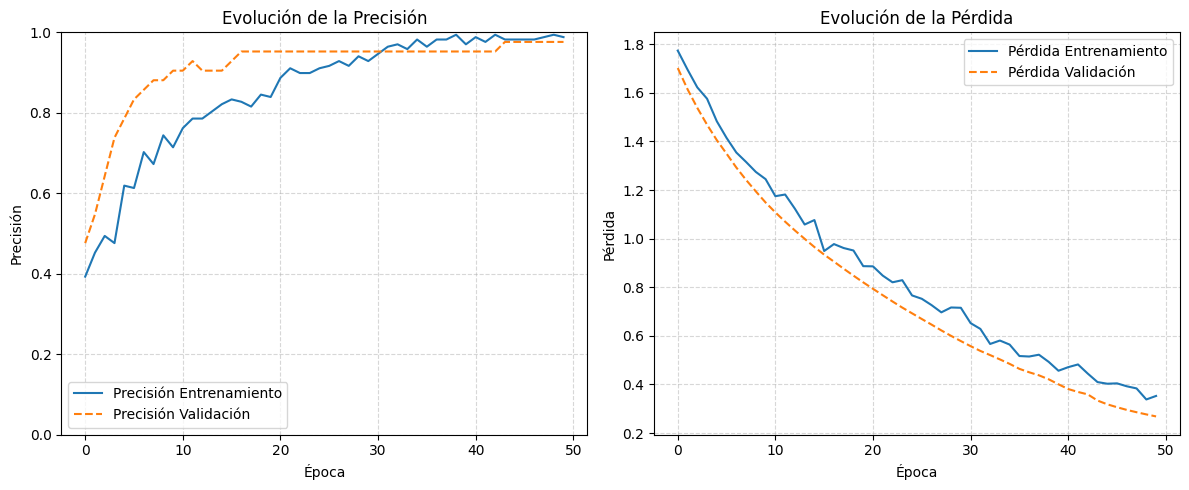

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/stepWARNING:tensorflow:6 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002A9BDC60DC0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step


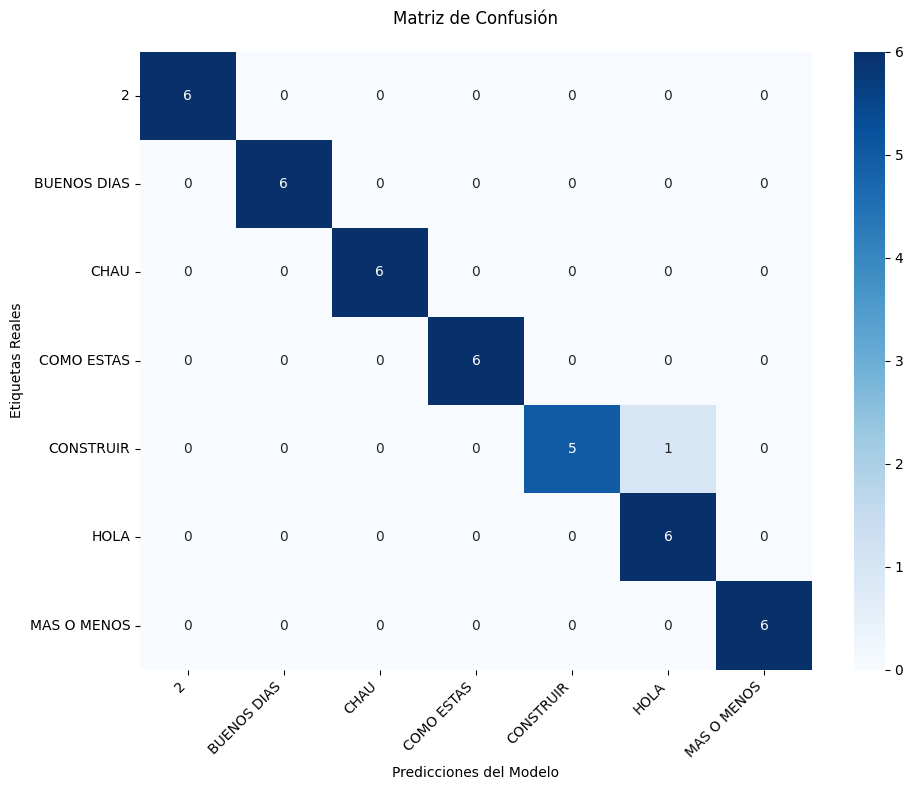


Reporte de Clasificación:
              precision    recall  f1-score   support

           2      1.000     1.000     1.000         6
 BUENOS DIAS      1.000     1.000     1.000         6
        CHAU      1.000     1.000     1.000         6
  COMO ESTAS      1.000     1.000     1.000         6
   CONSTRUIR      1.000     0.833     0.909         6
        HOLA      0.857     1.000     0.923         6
 MAS O MENOS      1.000     1.000     1.000         6

    accuracy                          0.976        42
   macro avg      0.980     0.976     0.976        42
weighted avg      0.980     0.976     0.976        42


Modelo guardado en gesture_model_me_10_90_pruebas_2.h5
INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmptlondtyh\assets


INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmptlondtyh\assets


Saved artifact at 'C:\Users\juanp\AppData\Local\Temp\tmptlondtyh'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 90, 126), dtype=tf.float32, name='keras_tensor_74')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2927852253280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927848456960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927827130448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927925602160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927925603040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927925606208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927925599344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927925607440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927925604976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2927925824144: TensorSpec(shape=(), dtype=tf.resource, name=None)

Modelo 

In [84]:
if __name__ == "__main__":
    main()